## The Binomial Distribution

In [3]:
from scipy.stats import binom
n = 2 # 2 experiments
p = 0.5 # prob. of success
k = 1 # amount of success
binom.pmf(k, n, p)  # probability of obtaining exactly k 
                    # successes from n experiments

0.5

In [4]:
import numpy as np
ks = np.arange(n+1) # [0, 1, 2]
ps = binom.pmf(ks, n, p) # probability of obtaining 
                         # exactly 0, 1 and 2, respectively 
                         # from n experiments
ps

array([0.25, 0.5 , 0.25])

In [5]:
from empiricaldist import Pmf
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [6]:
def make_binomial(n, p):
    ks = np.arange(n+1) # all possible amounts of success
    ps = binom.pmf(ks, n, p) # probability of obtaining 
                             # exactly each possible 
                             # amount of success from n
                             # experiments
    return Pmf(ps, ks)

## The Euro Problem 

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKays asks] do these data give evidence that the coin is biased rather than fair?"

Two steps to answer the question:

1. Use binomial distribution to see where that 7% came from.

2. Then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.

### Step 1

**Use binomial distribution to see where that 7% came from.**

<AxesSubplot:>

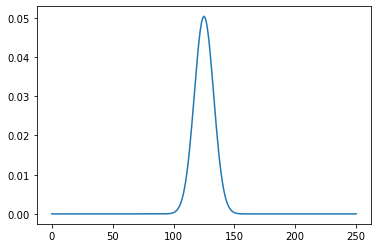

In [7]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.plot()

In [8]:
pmf_k.max_prob() # obtain 125 successes is the most 
                 # probably event

125

In [9]:
pmf_k[125] # the prob. of most probably event is 5%

0.05041221314731537

In [10]:
pmf_k[140] # the prob. of the event that occurred is 0.8%

0.008357181724917673

In [11]:
pmf_k.prob_ge(140) # the probability of getting 140 
                   # or more successes is 3.3%

0.033210575620022706

In [12]:
pmf_k.prob_le(110) # the probability of getting 110 
                   # or less successes is 3.3%

0.033210575620022706

**The probability that an event 15 units or more away from the most probable (125):**

$$= P(x<=125-15) + P(x>=125+15)$$
$$= P(x<=110) + P(x>=140)$$

$$ P(x>=140) = 3.3%$$
$$ P(x<=110) = 3.3%$$

$$= 6.6\% = 7\%$$

### Step 2

**Then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.**

## Bayesian Estimation 

<AxesSubplot:>

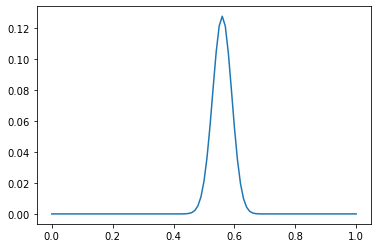

In [13]:
hypos = np.linspace(0, 1, 101) # 101 elements between 0 and 1 
                               # equally spaced
prior = Pmf(1, hypos)

likelihood_heads = hypos
likelihood_tails = 1 - hypos
likelihood = {
    "H": likelihood_heads,
    "T": likelihood_tails
}

dataset = "H" * 140 + "T" * 110

def update_euro(pmf, dataset):
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()

posterior = prior.copy()
update_euro(posterior, dataset)
posterior.plot()

In [14]:
posterior.max_prob()

0.56

**Conclusion**

* If the p is 0.56 (instead of 0.5) the most probable result will be the one that occurred (140 heads)

* Previously we took a subjective value for the p (0.5) and the most probable result was 125 successes. Now we have estimated the value of the p from the result (where 140 successes is the most probable) and in this way the result is a p = 0.56

    *Where p is the __probability of success in binomial dist.__*

In [15]:
# demostration of previus conclusion
pmf = make_binomial(n=250, p=0.56)
pmf.max_prob()

140

## Triangle Prior 

<AxesSubplot:>

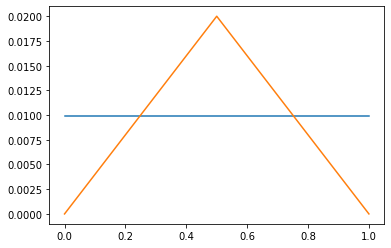

In [16]:
# uniform prior vs triangle prior

uniform = Pmf(1, hypos, name="uniform")
uniform.normalize()
uniform.plot()

ramp_up = np.arange(50) # 1, 2, ..., 50
ramp_down = np.arange(50, -1, -1) # 49, 48, ..., 1
a = np.append(ramp_up, ramp_down)
triangle = Pmf(a, hypos, name="triangle")
triangle.normalize()
triangle.plot()

<AxesSubplot:>

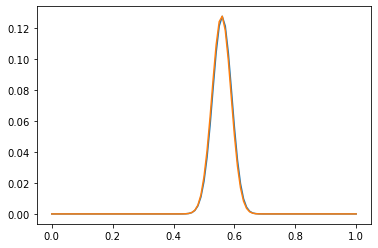

In [17]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

uniform.plot()
triangle.plot()

**Conclusions**

No diferences between use triangle prior or uniform prior, finally twice, finally both converge at some point

**Swamping the priors**: With enough data, people who start with different priors will tend to converge on the same posterior distribution.

## The Binomial Likelihood Function

Previus update binomial function (```update_euro()```) is $O(n^2)$, because '*' operation is $O(n)$ and its inside a loop $O(n)$. 

We can do the same with $O(n)$ complexity, for this I use the formula of binomial distribution:

$$\binom{n}{k} p^k (1-p)^{n-k}$$


In [18]:
from scipy.stats import binom

def update_binomial(pmf, data):
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [19]:
uniform2 = Pmf(1, hypos, name="uniform2")
data = 140, 250
update_binomial(uniform2, data)

# check if its the same
np.allclose(uniform, uniform2)

True

## Exercises

**Exercise 1**

In Major League Baseball, most players have a batting average between 200 and 330, which means that their probability of getting a hit is between 0.2 nad 0.33

Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

**Solution**
    
1. Construct the prior

2. Calculate the posterior

<AxesSubplot:>

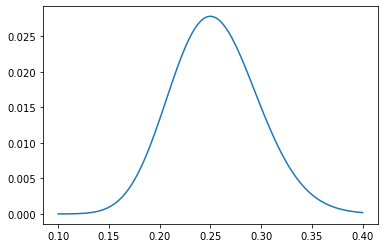

In [20]:
# step 1: Contruct the prior

hypos = np.linspace(0.1, 0.4, 101) # las posibles probabilidades de hit para un bateador
prior = Pmf(1, hypos) # linear prior
likelihood = {
    "Y": hypos, # dado que la hipotesis es verdad, la prob de "Y" (haga un hit) seria la misma
    "N": 1-hypos # dado que la hipotesis es verdad, la prob de "N" (no hit) seria 1-hypos[i], 
                 # de que SÍ haga un hit
}
dataset = "Y" * 25 + "N" * 75
for data in dataset:
    prior *= likelihood[data] # actualizamos el prior
prior.normalize()
prior.plot()

<AxesSubplot:>

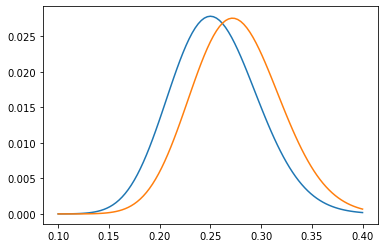

In [21]:
posterior = prior.copy()
dataset = "YYY"
for i in dataset:
    posterior *= likelihood[i]
posterior.normalize()
prior.plot()
posterior.plot()

In [22]:
posterior.max_prob() # lo más probable es que tenga un promedio de bateo de 0.271,
                     # y la prob de esto es 2.76%, todos los demas promedios de 
                     # son menores a 2.76%

0.271

In [23]:
print("round:\t", np.around(posterior, 4)[posterior.max_prob()])
posterior[posterior.max_prob()]

round:	 0.0276


0.027563807265634517

**Exercise 2**

Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. One way to improve the accuracy of the results is randomized response.

As an example, suppose want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie. You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

If they get heads, they report YES.

If they get tails, they honestly answer the question “Do you cheat on your taxes?”

If someone says YES, we don’t know whether they actually cheat on their taxes; they might have flipped yes. Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs. Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes? What is the most likely quantity in the posterior distribution?


In [24]:
hypos = np.linspace(0, 1, 101) # [0, 0.01, 0.02, 0.03, ... 1]
prior = Pmf(1, hypos)
"""
* 50% de los que dijeron "YES" porque salio cara, por lo que 
  los podemos descartar, de esta forma, el porcentaje es de 
  los que dijeron "YES" debido a que evaden impuestos es hypos
  sobre el nuevo total (T-0.5T)
  (T = 100)
  
Entonces calculamos el likelihood:
P(data/hypo)
  
    Ejemplo
    Prob de que la persona diga "YES" dado que la probabilidad de 
    que evada impuestos es de 40%:
        data = "Y"
        hypo = 0.4 (40%)
        P("Y"/0.4):
            cantidad de "Y" = 0.5T + 0.4(0.5T) = 0.7T
            total = T
            Probabilidad = 0.7T/T = 0.7 

Generalizando:
P("Y"/hypo) = 0.5 + hypo * (0.5)
P("N"/hypo) = 1- P("Y"/hypo) = 0.5 - hypo * (0.5)
"""
likelihood = {
    "Y": 1/2 + hypos/2,
    "N": 1/2 - hypos/2
}
print(likelihood["Y"][:10])
print(likelihood["N"][:10])

[0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535 0.54  0.545]
[0.5   0.495 0.49  0.485 0.48  0.475 0.47  0.465 0.46  0.455]


Hipostesis más probable:
* 60.0 % de las personas evaden impuestos
* probabilidad de hipotesis: 5.01 %


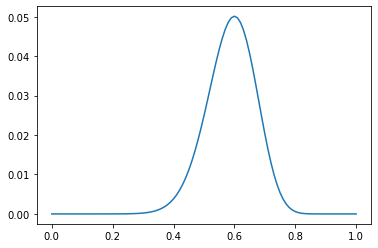

In [25]:
dataframe = 80*"Y" + 20*"N"
posterior = prior.copy()
for i in dataframe:
    posterior *= likelihood[i]
posterior.normalize()
posterior.plot()
print("Hipostesis más probable:")
print("*", posterior.max_prob()*100, "% de las personas evaden impuestos")
print("* probabilidad de hipotesis:", np.around(posterior, 4)[posterior.max_prob()]*100, "%")

**Exercise 3**

Suppose you want to test whether a coin is fair, but you don’t want to spin it hundreds of times. So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate. Specifically, suppose the probability is y=0.2 that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of x? What happens as you vary the value of y?

In [54]:
# error de 20%
y = 0.2
prior = Pmf(1, np.linspace(0,1,101))
hypos = prior.qs
# hypos son las posibles probabilidades que tiene la moneda de tener una cara

**Likelihood P(Data/Hypo)**
 
 Example
 
 **P("C"/0.4)**
 
     Data: el robot detecta cara ("C")
     Hypo: 0.4 (40% de obtener cara (verdaderamente))
     P("C"/0.4) = 0.4 * (1-error) + 0.6 * error
 
![likelihood](files/cap3-lh.jpg "likelihood 'C'")

0.6

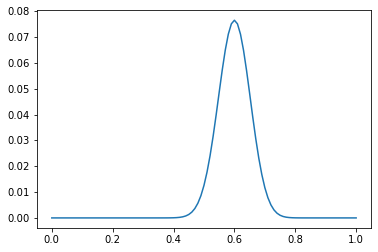

In [60]:
likelihood = {
    "C": hypos*(1-y) + (1-hypos)*y ,
    "S": hypos*y + (1-hypos)*(1-y)   
}
dataset = 140 * "C" + 110 * "S"
posterior = prior.copy()
for i in dataset:
    posterior *= likelihood[i]
posterior.normalize()
posterior.plot()
posterior.max_prob()

0.5

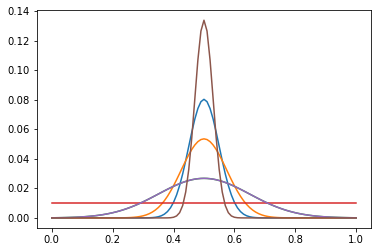

In [77]:
def ex3(hypos, dataset, y):
    prior = Pmf(1, hypos) # linear prior
    likelihood = {
        "C": hypos * (1-y) + (1-hypos) * y,
        "S": hypos * y + (1-hypos) * (1-y)
    }
    posterior = prior.copy()
    for i in dataset:
        posterior *= likelihood[i]
    posterior.normalize()
    return posterior

dataset = 140 * "C" + 110 * "S"
dataset = 140 * "C" + 140 * "S"


ex3(np.linspace(0,1,101), dataset, 0.2).plot() # azul
ex3(np.linspace(0,1,101), dataset, 0.3).plot() # amarillo
ex3(np.linspace(0,1,101), dataset, 0.4).plot() # verde
ex3(np.linspace(0,1,101), dataset, 0.5).plot() # rojo 
ex3(np.linspace(0,1,101), dataset, 0.6).plot() # morado
ex3(np.linspace(0,1,101), dataset, 0.0).plot() # guinda
# cuando tiene 0.5 de error el likelihood seria 
# c: hypos*0.5 + (1-hypos)*0.5 = 0.5*(hypos+1-hypos) = 1*0.5 = 0.5
# s: hypos*0.5 + (1-hypos)*0.5 = 0.5*(hypos+1-hypos) = 1*0.5 = 0.5

ex3(np.linspace(0,1,101), dataset, 0.2).max_prob()